In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_max_distance_to_target_surface, contact_optimization, show_selected_joints, get_fixed_boundary_joint)

import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.09982061776030171
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('chicago_bean_1', thickness, width, weaving_dir)

0.033273539253433904 0.0023291477477403733


In [4]:
import py_newton_optimizer
# Optimization parameters.
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-8
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 0.01
sw = 10
drw = 0.01
dsw = 0.1

In [21]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [22]:
curved_linkage.setExtendedDoFsPSRL(np.load('../results/chicago_bean_1/chicago_bean_1_dof.npy'))

In [23]:
curved_linkage.attraction_weight = 1e-5

In [24]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [25]:
OPTS.niter = 10000

In [26]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.00132938	1.13898	1.13898	1	1
1	0.000119252	0.0882615	0.0882615	1	1
2	6.5597e-05	0.0218381	0.0218381	1	1
3	5.01577e-05	0.0101792	0.0101792	1	1
4	4.00166e-05	0.00504941	0.00504941	1	1
5	3.23147e-05	0.00261929	0.00261929	1	1
6	2.6659e-05	0.00163259	0.00163259	1	1
7	2.29063e-05	0.00118908	0.00118908	1	1
8	2.08599e-05	0.000761262	0.000761262	1	1
9	1.99962e-05	0.000440798	0.000440798	1	1
10	1.96971e-05	0.00025751	0.00025751	1	1
11	1.95991e-05	0.00013312	0.00013312	1	1
12	1.95659e-05	5.8547e-05	5.8547e-05	1	1
13	1.95539e-05	2.34526e-05	2.34526e-05	1	1
14	1.95491e-05	8.43537e-06	8.43537e-06	1	1
15	1.95467e-05	3.61873e-06	3.61873e-06	1	1
16	1.95447e-05	3.23919e-06	3.23919e-06	1	1
17	1.95426e-05	3.03426e-06	3.03426e-06	1	1
18	1.95402e-05	2.85087e-06	2.85087e-06	1	1
19	1.95376e-05	3.20675e-06	3.20675e-06	1	1
20	1.95352e-05	4.23383e-06	4.23383e-06	1	1
21	1.95333e-05	4.77128e-06	4.77128e-06	1	1
22	1.95322e-05	3.22027e-06	3.22027e-06	1	0
23	1.95275e-05	0.000732478	0.000732478	1	0
24	1.95234e-05	

In [27]:
import structural_analysis

In [28]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)

In [45]:
cfm[:, 0].argsort()[-2]

88

In [30]:
max(cfm[:, 0])

1.0137817204843287e-06

Coefficient of Friction Percentiles 50, 75, 90:  0.4726834178837388 1.3150448513990678 2.753756161921686


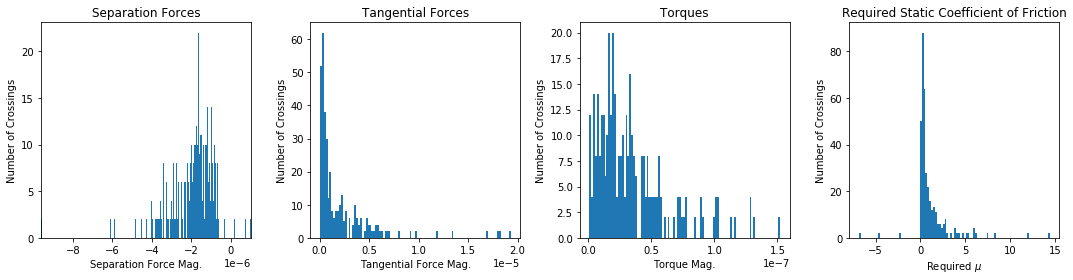

In [44]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

### Deactivate Crossing

In [31]:
import deactivate_crossing_helper
importlib.reload(deactivate_crossing_helper)
from deactivate_crossing_helper import (write_deactivated_linkage, copy_over_under, get_segment_index_from_joints, get_angle_from_kappa, get_kappa_from_angle, no_resample_deactivation, resample_deactivation, get_neighbors)

In [32]:
def create_deactivated_linkage(original_linkage, deactive_index, original_model_name, deactivated_model_name):
    ju = original_linkage.joint(deactive_index)
    nbs = ju.neighbors()
    print('neighbors: ', nbs)
    deactive_vertex_map = [i if i < deactive_index else i - 1 for i in range(original_linkage.numJoints())]
    write_deactivated_linkage(original_model_name, deactivated_model_name, deactive_index, deactive_vertex_map, nbs)
    
    with so(): deactivate_curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = deactivated_model_name, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, interleaving_type=elastic_rods.InterleavingType.weaving, use_constant_width=False)
    deactivate_curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
    curved_save_tgt_joint_pos = deactivate_curved_linkage.jointPositions();
    deactivate_curved_linkage.attraction_weight = 1e-5

#     Copy the over under assignment from the original model since BFS will not find a perfect over under in the new topology
    copy_over_under(deactivate_curved_linkage, original_linkage, deactive_vertex_map, deactive_index)
    vf = show_selected_joints(deactivate_curved_linkage, [deactive_vertex_map[12], deactive_vertex_map[258]])
    deactivate_curved_linkage.setDoFs(deactivate_curved_linkage.getDoFs())

    resample_deactivation(deactivate_curved_linkage, original_linkage, deactive_vertex_map, nbs, deactive_index, io)
    return deactivate_curved_linkage, deactive_vertex_map

In [46]:
deactive_index = 88

In [47]:
deactivated_model_name = ('/'.join(io.MODEL_PATH.split('/')[:-1] + [io.MODEL_NAME + '_deactive_joint_{}.obj'.format(deactive_index)]))

In [48]:
deactivate_linkage, deactive_vertex_map = create_deactivated_linkage(curved_linkage, deactive_index, io.MODEL_PATH, deactivated_model_name)

neighbors:  [87, 293, 89, 323]
740
741


In [49]:
deactivate_curved_linkage_view = linkage_vis.LinkageViewer(deactivate_linkage)
deactivate_curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [50]:
topColor =[150/255., 150/255., 150/255.]
bottomColor =[79/255., 158/255., 246/255.]
heights = deactivate_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [51]:
deactivate_curved_linkage_view.update(scalarField = colors)

In [52]:
deactivate_fixed_boundary_joints = get_fixed_boundary_joint(deactivate_linkage)

In [53]:
def eqm_callback(prob, i):
    deactivate_curved_linkage_view.update()

In [54]:
elastic_rods.compute_equilibrium(deactivate_linkage, callback = eqm_callback, options = OPTS, fixedVars = deactivate_fixed_boundary_joints)

0	0.0244971	4.121	4.121	1	1
1	0.0119482	0.76251	0.76251	1	1
2	0.00968504	0.277383	0.277383	1	1
3	0.00830262	0.15343	0.15343	1	1
4	0.00786822	0.126615	0.126615	1	1
5	0.00724386	0.10505	0.10505	1	1
6	0.00699488	0.0949598	0.0949598	1	1
7	0.00658942	0.0846814	0.0846814	1	1
8	0.00641086	0.0801317	0.0801317	1	1
9	0.0060965	0.0743099	0.0743099	1	1
10	0.00558609	0.069183	0.069183	1	1
11	0.00536594	0.062484	0.062484	1	1
12	0.00497938	0.0587313	0.0587313	1	1
13	0.0048039	0.0555089	0.0555089	1	1
14	0.00449161	0.0526234	0.0526234	1	1
15	0.00435037	0.049903	0.049903	1	1
16	0.00409885	0.0473441	0.0473441	1	1
17	0.00398425	0.0452007	0.0452007	1	1
18	0.0037768	0.0431565	0.0431565	1	1
19	0.00342165	0.0445962	0.0445962	1	1
20	0.00327305	0.0363522	0.0363522	1	1
21	0.00302221	0.0373423	0.0373423	1	1
22	0.00291221	0.0314473	0.0314473	1	1
23	0.00272225	0.0305702	0.0305702	1	1
24	0.00242703	0.0385306	0.0385306	1	1
25	0.00230382	0.023502	0.023502	1	1
26	0.0021057	0.0224694	0.0224694	1	1
27	0.00181513	0.037224

In [55]:
vf = show_selected_joints(deactivate_linkage, [deactive_vertex_map[87], deactive_vertex_map[89], deactive_vertex_map[293], deactive_vertex_map[323]])
deactivate_curved_linkage_view.update(vectorField = vf, scalarField = colors)